In [ ]:
import torch
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn
import torch.optim as optim
from torch import LongTensor, FloatTensor
from torch.autograd import Variable

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler

from scipy import stats
from scipy.special import log1p

import os
import time
from typing import Tuple

import seaborn as sns

In [ ]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(device)

cuda


In [ ]:
df = pd.read_csv("data_train_log_return.csv", header=None).drop(columns=0)

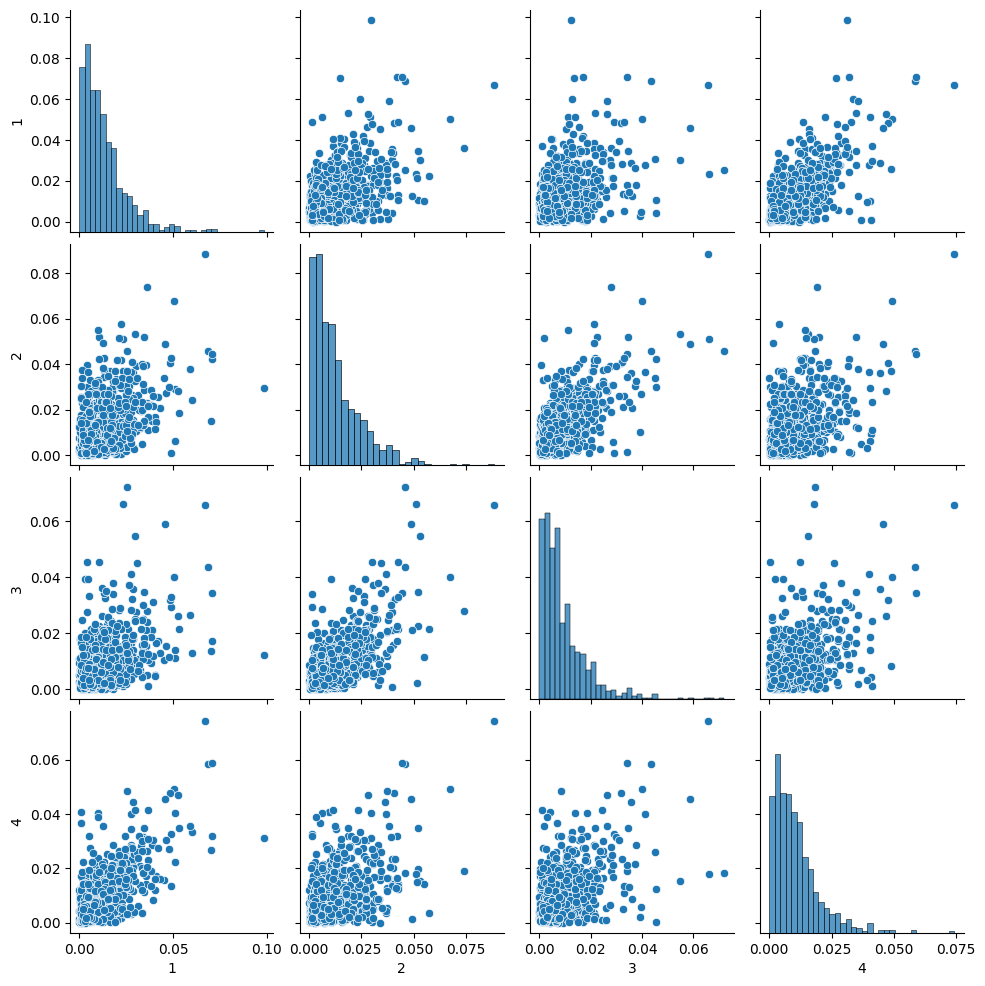

In [ ]:
sns.pairplot(df)

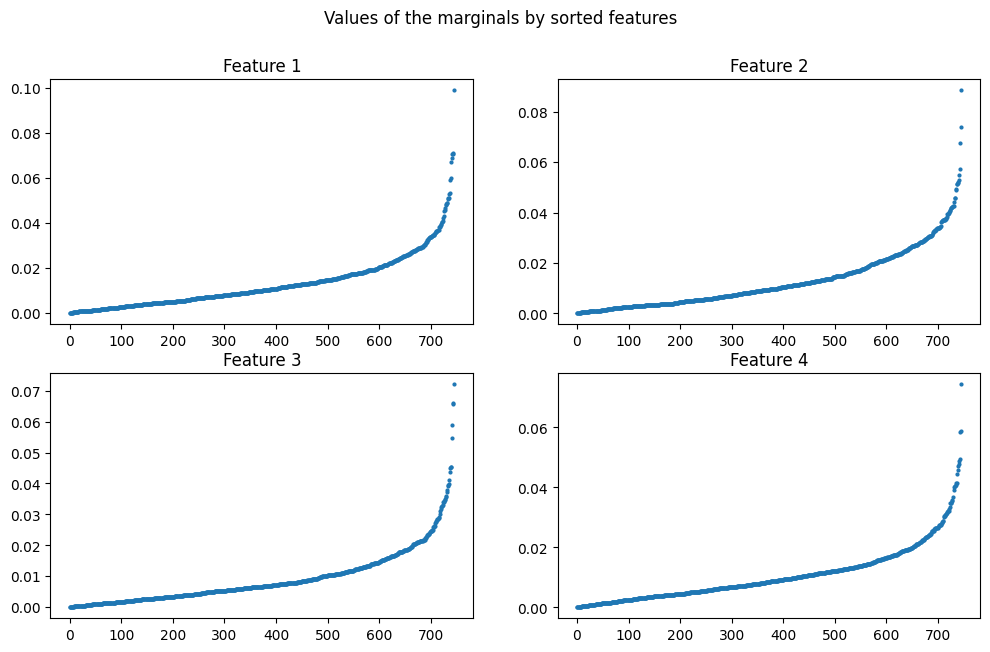

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(12,7))

X_plot = df.values

axes[0, 0].plot(np.sort(X_plot[:,0]), "o", markersize=2)
axes[0, 0].set_title('Feature 1')

axes[0, 1].plot(np.sort(X_plot[:,1]), "o", markersize=2)
axes[0, 1].set_title('Feature 2')

axes[1, 0].plot(np.sort(X_plot[:,2]), "o", markersize=2)
axes[1, 0].set_title('Feature 3')

axes[1, 1].plot(np.sort(X_plot[:,3]), "o", markersize=2)
axes[1, 1].set_title('Feature 4')

fig.suptitle('Values of the marginals by sorted features')
plt.show()

In [ ]:
X_train, X_test = train_test_split(df, test_size=0.2)
X_train = X_train.values
X_test = X_test.values

We will refer as hacks the advices to make GAN works throughout the notebook. You can find them here : https://github.com/soumith/ganhacks

In [ ]:
def absolute_kental_error(X_pred, X_true):
  ''' Computation of the Absolute Kendal Error '''
  n = len(X_true)
  X_1 = X_true[:,0]
  X_2 = X_true[:,1]
  X_3 = X_true[:,2]
  X_4 = X_true[:,3]

  Z = np.zeros(n)

  Xtilde_1 = X_pred[:,0]
  Xtilde_2 = X_pred[:,1]
  Xtilde_3 = X_pred[:,2]
  Xtilde_4 = X_pred[:,3]

  Z_tilde = np.zeros(n)

  for i in range(n):
    for j in range(n):
      # Adding the indicators functions
      if i != j:
        Z[i] += (X_1[j] < X_1[i]) and (X_2[j] < X_2[i]) and (X_3[j] < X_3[i]) and (X_4[j] < X_4[i])
        Z_tilde[i] += (Xtilde_1[j] < Xtilde_1[i]) and (Xtilde_2[j] < Xtilde_2[i]) and (Xtilde_3[j] < Xtilde_3[i]) and (Xtilde_4[j] < Xtilde_4[i])

  Z = Z/(n-1)
  Z_tilde = Z_tilde/(n-1)

  Z = np.sort(Z)
  Z_tilde = np.sort(Z_tilde)

  return np.mean(np.abs(Z - Z_tilde))

In [ ]:
def marginal_anderson_darling(X_pred, X_true):
  ''' Computation of the Marginal Anderson Darling '''
  n = len(X_true)
  Z = np.zeros(n)

  # Sorting the predictions
  X_pred[:,0] = np.sort(X_pred[:,0])
  X_pred[:,1] = np.sort(X_pred[:,1])
  X_pred[:,2] = np.sort(X_pred[:,2])
  X_pred[:,3] = np.sort(X_pred[:,3])

  u = np.zeros((n,4))
  W = np.zeros(4)

  for tau in range(4):
    for i in range(n):
      u[i,tau] = (np.sum(X_true[:,tau] <= X_pred[i,tau]) + 1)/(n+2)
    W[tau] = -n-sum([(2*i-1)*(np.log(u[i,tau])+np.log(1-u[n-i-1,tau])) for i in range(n)])/n

  return np.sum(W)/4

## I. First solution: a conventionnal GAN

In [ ]:
# Hack 1 : Normalize the data so that it is in [-1,1]
scaler = MinMaxScaler(feature_range=(-1, 1))
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
batch_size=8
X_train_torch = torch.from_numpy(X_train_scaled).to(torch.float32).to(device)
X_train_dataloader = TensorDataset(X_train_torch)
X_train_dataloader = DataLoader(X_train_dataloader, batch_size=batch_size, shuffle=True)

In [ ]:
class Generator(nn.Module):
  def __init__(self, n_input, n_hidden_size, n_output=4, activation=nn.Tanh()):
    super(Generator, self).__init__()
    self.linear1 = nn.Linear(n_input, n_hidden_size)
    # Hack 4 : Use batch normalization : doesn't work
    self.batchnorm1 = nn.BatchNorm1d(n_hidden_size)
    self.relu1 = nn.LeakyReLU()
    # Hack 17 : Use dropout in both train and test
    self.dropout1 = nn.Dropout()
    self.linear2 = nn.Linear(n_hidden_size, n_output)
    # Hack 1 : Use tanh for the generator
    self.activation = activation

  def forward(self, x):
    x = self.linear1(x)
    x = self.relu1(x)
    x = self.dropout1(x)
    x = self.linear2(x)
    return self.activation(x)

In [ ]:
class Discriminator(nn.Module):
  def __init__(self, n_input, n_hidden_size1, n_hidden_size2):
    super(Discriminator, self).__init__()
    self.linear1 = nn.Linear(n_input, n_hidden_size1)
    self.batchnorm1 = nn.BatchNorm1d(n_hidden_size1)
    self.relu1 = nn.LeakyReLU()
    self.linear2 = nn.Linear(n_hidden_size1, n_hidden_size2)
    self.batchnorm2 = nn.BatchNorm1d(n_hidden_size2)
    self.relu2 = nn.LeakyReLU()
    self.linear3 = nn.Linear(n_hidden_size2, 1)
    self.sigmoid3 = nn.Sigmoid()

  def forward(self, x):
    x = self.linear1(x)
    x = self.relu1(x)
    x = self.linear2(x)
    x = self.relu2(x)
    x = self.linear3(x)
    return self.sigmoid3(x)

In [ ]:
n_input_G = 8
n_hidden_sizeG = 20
n_hidden_sizeD1 = 30
n_hidden_sizeD2 = 15
n_output_G = 4

generator = Generator(n_input_G, n_hidden_sizeG, n_output_G).to(device)
discriminator = Discriminator(n_output_G, n_hidden_sizeD1, n_hidden_sizeD2).to(device)

n_epoch_GAN = 100

In [ ]:
criterion = nn.BCELoss()

optimizerG = optim.Adam(generator.parameters(), lr=0.0001)
optimizerD = optim.Adam(discriminator.parameters(), lr=0.0001)

In [ ]:
from typing import Callable

def infer_GAN(generator : Generator, X_infer : np.ndarray = X_test):
  with torch.no_grad():
    noisy_input = Variable(torch.randn(len(X_infer), n_input_G)).to(device)
    # the generated data from the input that was scaled to be in [-1,1]
    fakeData = generator(noisy_input).cpu().numpy()
    # 'descaling' the data, because we suppose they are sampled according to
    # the distribution of X_test which has been normalized to be in [-1,1]
    fakeData = scaler.inverse_transform(fakeData)
    return fakeData

def train_GAN(dataloader : DataLoader,
              generator : Generator,
              discriminator : Discriminator,
              n_epoch : int,
              verbeux : bool = True,
              gaussian : bool = True,
              metrics : bool = True,
              infer_func : Callable = infer_GAN):

  absolute_kental_error_train_list = []
  absolute_kental_error_test_list = []

  marginal_anderson_darling_train_list = []
  marginal_anderson_darling_test_list = []

  for epoch in range(n_epoch):

    # Hack 13 :  Noise decay over time
    noise = 1e-5*max(1 - (epoch/n_epoch), 0)
    loss_G_list = []
    loss_D_list = []

    for x in X_train_dataloader:
      x = x[0]

      ##############################
      # OPTIMIZE the discriminator #
      ##############################

      batch_size = x.shape[0]
      # Hack 6 : Noisy labels
      trueTensor = 0.7+0.3*torch.rand(batch_size)
      falseTensor = 0.3*torch.rand(batch_size)

      # Hack 6 : Flip labels sometimes (make sure the generator is not too good at tricking the discriminator too fast). Hence we sometimes reverse what the generator will believe is true and false
      probFlip = torch.rand(batch_size) < 0.05
      probFlip = probFlip.float()
      trueTensor, falseTensor = (
          probFlip * falseTensor + (1 - probFlip) * trueTensor,
          probFlip * trueTensor + (1 - probFlip) * falseTensor,
      )
      trueTensor = trueTensor.view(-1, 1).to(device)
      falseTensor = falseTensor.view(-1, 1).to(device)

      # Compute the loss induced by the true sample
      # Hack 13 : Add noise to the real sample for the discriminator only
      if gaussian:
        realSample = discriminator(x + noise*torch.randn_like(x).to(device))
      else:
        realSample = discriminator(x + noise*torch.rand_like(x).to(device))
      realLoss = criterion(realSample, trueTensor.expand_as(realSample))

      # Compute the loss induced by the generated sample
      # Hack 3 : Input of the generator should not be uniform noise ideally (ie gaussian noise)
      if gaussian:
        noisy_input = Variable(torch.randn(batch_size, n_input_G)).to(device)
      else:
        noisy_input = Variable(torch.rand(batch_size, n_input_G)).to(device)
      fakeData = generator(noisy_input)
      # We detach (prevent autograd) to only train the discriminator
      fakeSample = discriminator(fakeData.detach())
      fakeLoss = criterion(fakeSample, falseTensor.expand_as(fakeSample))

      # Total loss is the sum of the fake loss and the real loss
      lossD = realLoss + fakeLoss
      loss_D_list.append(lossD)
      optimizerD.zero_grad()
      lossD.backward()
      # Gradient clipping
      torch.nn.utils.clip_grad_norm_(discriminator.parameters(),20)
      optimizerD.step()

      ##############################
      # OPTIMIZE the generator #
      ##############################

      fakeSample = discriminator(fakeData)
      trueTensor = 0.9*torch.ones(batch_size).view(-1, 1).to(device)
      # We compare the result of the generated data via the discriminator to an tensor of 1 (the generator successfully trick the discriminator)
      lossG = criterion(fakeSample, trueTensor.expand_as(fakeSample))
      loss_G_list.append(lossG)
      optimizerG.zero_grad()
      lossG.backward()
      torch.nn.utils.clip_grad_norm_(generator.parameters(),20)
      optimizerG.step()

    if metrics:
      # generating values from the trained GAN
      fake_train_Data = infer_func(generator, X_train)
      # Computea absolute kental error
      absolute_kental_error_train = absolute_kental_error(fake_train_Data, X_train)
      # Computea Marginal anderson darling
      marginal_anderson_darling_train = marginal_anderson_darling(fake_train_Data, X_train)

      # generating values from the trained GAN
      fake_test_Data = infer_func(generator, X_test)
      # Compute absolute kental error
      absolute_kental_error_test = absolute_kental_error(fake_test_Data, X_test)
      # Computea Marginal anderson darling
      marginal_anderson_darling_test = marginal_anderson_darling(fake_test_Data, X_test)

      if verbeux:
        print(end="\r")
        print(f"Epoch: {epoch} : ", end='')
        print(f"lossG: {(sum(loss_G_list))/len(X_train_dataloader)} | ", end="")
        print(f"lossD: {(sum(loss_D_list))/len(X_train_dataloader)} | ", end="")
        print(f"Absolute kental error Train : {absolute_kental_error_train} | ", end="")
        print(f"Absolute kental error Test: {absolute_kental_error_test} |", end="")
        print(f"Marginal Anderson Darling Train : {marginal_anderson_darling_train} | ", end="")
        print(f"Marginal Anderson Darling Test: {marginal_anderson_darling_test}", end="")

      absolute_kental_error_train_list.append(absolute_kental_error_train)
      absolute_kental_error_test_list.append(absolute_kental_error_test)
      marginal_anderson_darling_train_list.append(marginal_anderson_darling_train)
      marginal_anderson_darling_test_list.append(marginal_anderson_darling_test)

  return absolute_kental_error_train_list, absolute_kental_error_test_list, marginal_anderson_darling_train_list, marginal_anderson_darling_test_list



In [ ]:
absolute_kental_error_train_list, absolute_kental_error_test_list, marginal_anderson_darling_train_list, marginal_anderson_darling_test_list = train_GAN(X_train_dataloader,generator, discriminator, n_epoch_GAN)

Epoch: 99 : lossG: 0.6918926239013672 | lossD: 1.3868411779403687 | Absolute kental error Train : 0.03249393717218431 | Absolute kental error Test: 0.05794183445190157 |Marginal Anderson Darling Train : 5.189452811355807 | Marginal Anderson Darling Test: 1.369439096455011

In [ ]:
fakeData = infer_GAN(generator, X_train)
absolute_kental_error_train = absolute_kental_error(fakeData, X_train)
print(f"Absolute kental error Train: {absolute_kental_error_train}")
marginal_anderson_darling_train = marginal_anderson_darling(fakeData, X_train)
print(f"Marginal Anderson Darling Train: {marginal_anderson_darling_train}")

fakeData = infer_GAN(generator)
absolute_kental_error_test = absolute_kental_error(fakeData, X_test)
print(f"Absolute kental error Test: {absolute_kental_error_test}")
marginal_anderson_darling_test = marginal_anderson_darling(fakeData, X_test)
print(f"Marginal Anderson Darling Test: {marginal_anderson_darling_test}")

Absolute kental error Train: 0.041599458575376454
Marginal Anderson Darling Train: 7.853472620392267
Absolute kental error Test: 0.05879194630872484
Marginal Anderson Darling Test: 1.4616754607153695


In [ ]:
def plot_error(absolute_kental_error_train_list,
               absolute_kental_error_test_list,
               marginal_anderson_darling_train_list,
               marginal_anderson_darling_test_list,
               figsize : Tuple[int,int] = (12,7)) -> None:

    fig, axes = plt.subplots(2, figsize=figsize)

    axes[0].plot(absolute_kental_error_train_list, label="Train set")
    axes[0].plot(absolute_kental_error_test_list, label="Test set")
    axes[0].set_title('Absolute kendal error')
    axes[0].legend()

    axes[1].plot(marginal_anderson_darling_train_list, label="Train set")
    axes[1].plot(marginal_anderson_darling_test_list, label="Test set")
    axes[1].legend()
    axes[1].set_title('Marginal Anderson Darling')

    fig.suptitle('Plot of the errors')
    plt.show()

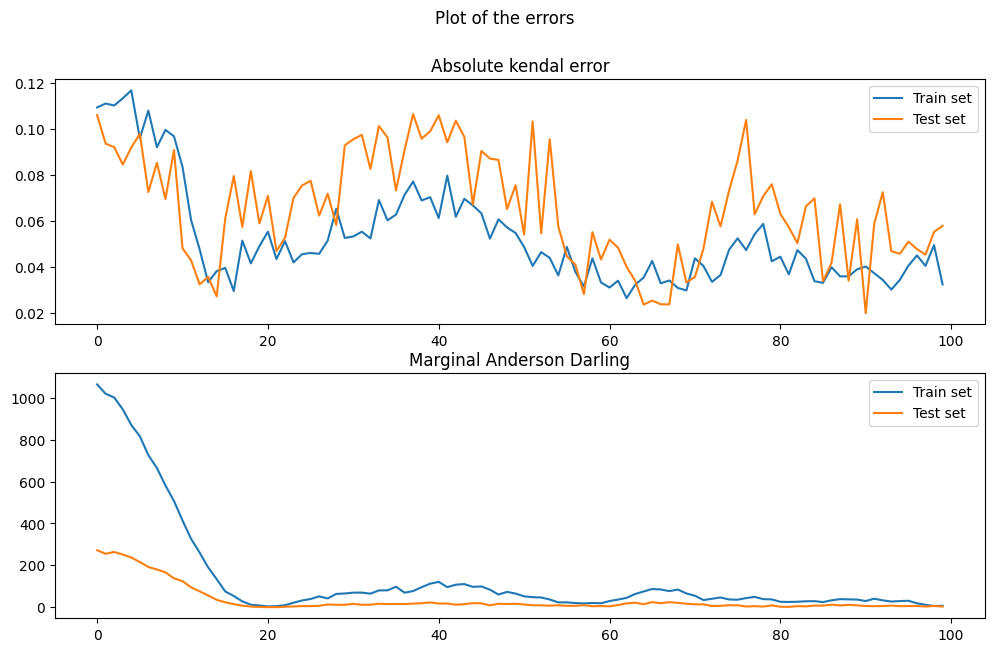

In [ ]:
plot_error(absolute_kental_error_train_list,
               absolute_kental_error_test_list,
               marginal_anderson_darling_train_list,
               marginal_anderson_darling_test_list)

In [ ]:
def plot_pair_plot(fakeData : np.ndarray, X_plot : np.ndarray = X_test):
  df_generated = pd.DataFrame(fakeData)
  df_generated["Type"] = "Generated Data"
  df_test_set = pd.DataFrame(X_test)
  df_test_set["Type"] = "Test Data"
  df_concat = pd.concat([df_generated, df_test_set])
  sns.pairplot(df_concat, hue="Type", plot_kws={"s": 5})

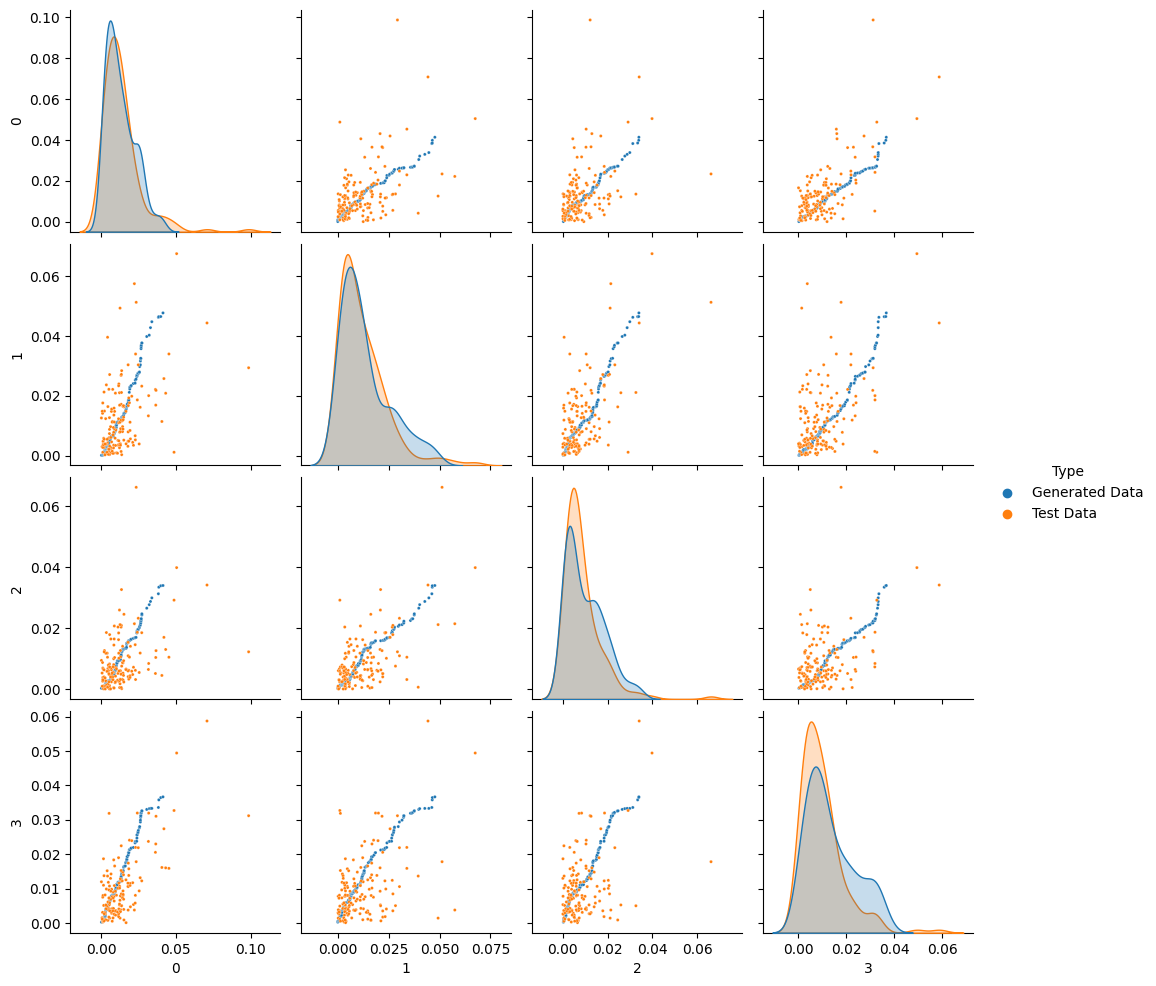

In [ ]:
plot_pair_plot(fakeData, X_test)

In [ ]:
def plot_generation(fakeData : np.ndarray, figsize : Tuple[int,int] = (12,7), X_plot : np.ndarray = X_test) -> None :

  fig, axes = plt.subplots(2, 2, figsize=figsize)

  X_plot_sort = np.sort(X_plot,axis=0)
  fakeData_sort = np.sort(fakeData,axis=0)

  axes[0, 0].plot(X_plot_sort[:,0], "x", markersize=2, label="Test set")
  axes[0, 0].plot(fakeData_sort[:,0], "o", markersize=2, label="Generated data")
  axes[0, 0].set_title('Feature 1')
  axes[0, 0].legend()

  axes[0, 1].plot(X_plot_sort[:,1], "x", markersize=2, label="Test set")
  axes[0, 1].plot(fakeData_sort[:,1], "o", markersize=2, label="Generated data")
  axes[0, 1].set_title('Feature 2')
  axes[0, 1].legend()

  axes[1, 0].plot(X_plot_sort[:,2], "x", markersize=2, label="Test set")
  axes[1, 0].plot(fakeData_sort[:,2], "o", markersize=2, label="Generated data")
  axes[1, 0].set_title('Feature 3')
  axes[1, 0].legend()

  axes[1, 1].plot(X_plot_sort[:,3], "x", markersize=2, label="Test set")
  axes[1, 1].plot(fakeData_sort[:,3], "o", markersize=2, label="Generated data")
  axes[1, 1].set_title('Feature 4')
  axes[1, 1].legend()

  fig.suptitle('Comparison of the generated data and the test data for the four different features')
  plt.show()

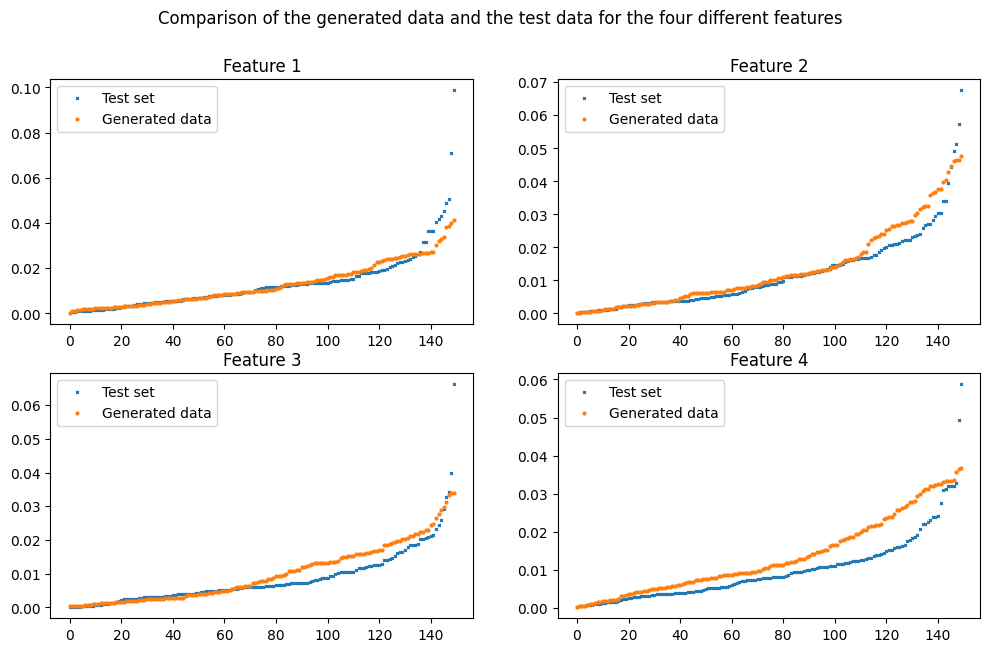

In [ ]:
plot_generation(fakeData)

## II. Second solution : Distribution shifting

This method is based on the one described in Bhatia, Siddharth, Arjit Jain, and Bryan Hooi. "Exgan: Adversarial generation of extreme samples." Proceedings of the AAAI Conference on Artificial Intelligence. Vol. 35. No. 8. 2021. (https://arxiv.org/pdf/2009.08454.pdf).

Before starting, we have to defined a measure of the extremness of the values. In our example, this can be defined naturally by the value of the data (each feature is in $\mathbf{R}^+$).

In the following, we will keep the paper's notation.

In [ ]:
def infer_distribution_shifting(generator_shifting, X_infer, scaler):
  with torch.no_grad() :
    noisy_input = Variable(torch.randn(len(X_infer), n_input_G)).to(device)
    fakeData_shifting = generator_shifting(noisy_input).cpu().numpy()
    fakeData_shifting = scaler.inverse_transform(fakeData_shifting)
  return fakeData_shifting

In [ ]:
def run_distribution_shifting(generator : Generator,
                              discriminator : Discriminator,
                              c : float,
                              k : int,
                              n_epoch : int,
                              verbeux : bool = True,
                              metrics : bool = True) -> list :

  '''
    c : the shift parameter
    k : iteration count
    n_epoch : number of epochs for the training of each GAN

  In addition to updating the generator and the discriminator, also returns the list
      of values of X_s'''

  n = X_train.shape[0]

  # the sorted tensor created from X_train, that will remain the same all along the training
  X = torch.from_numpy(X_train).to(torch.float32)
  X = torch.sort(X, descending=True, dim = 0)[0]

  # initializing X_s with X
  X_s = torch.clone(X)

  res = [X_s]

  absolute_kental_error_train_list=[]
  absolute_kental_error_test_list=[]
  marginal_anderson_darling_train_list=[]
  marginal_anderson_darling_test_list=[]

  for i in range(1,k+1) :

    if verbeux :
      if i > 1:
        print("\n")
      print(f"i = {i}:")

    # scaling X_s
    scaler2 = MinMaxScaler(feature_range=(-1, 1))
    X_s = torch.from_numpy(scaler2.fit_transform(X_s.cpu())).to(torch.float32).to(device)

    X_s_dataloader = TensorDataset(X_s)
    X_s_dataloader = DataLoader(X_s_dataloader, batch_size=batch_size, shuffle=True)

    # training the gan on the scaled X_s
    ake_train, ake_test, mad_train, mad_test = train_GAN(X_s_dataloader, generator_shifting, discriminator_shifting, n_epoch, verbeux, infer_func=lambda x,y:infer_distribution_shifting(x,y, scaler2), metrics=metrics)

    absolute_kental_error_train_list.extend(ake_train)
    absolute_kental_error_test_list.extend(ake_test)
    marginal_anderson_darling_train_list.extend(mad_train)
    marginal_anderson_darling_test_list.extend(mad_test)

    # recreating X_s
    X_s = torch.zeros_like(X_s)

    # putting the most extreme values of X in X_s (reminder: X is NOT normalized)
    n_samples_X = int((c**i)*n)
    X_s[:n_samples_X] = X[:n_samples_X]

    # generating data points using G (reminder: these points ARE normalized, as the
    # input X_s is normalized, so we will 'denormalize' them at the end)
    n_generation = int(np.ceil((n-n_samples_X)/c))

    with torch.no_grad() :
      noisy_input = Variable(torch.randn(n_generation, n_input_G)).to(device)
      fakeData = generator_shifting(noisy_input).cpu()
      fakeData = torch.from_numpy(scaler2.inverse_transform(fakeData)).to(torch.float32)

    # inserting the most extreme points of the generation in X_s
    n_samples_fakeData = n - n_samples_X
    fakeData = torch.sort(fakeData, descending=True, dim = 0)[0][:n_samples_fakeData]
    X_s[n_samples_X:] = fakeData

    res.append(X_s)

  return res, scaler2, absolute_kental_error_train_list, absolute_kental_error_test_list, marginal_anderson_darling_train_list, marginal_anderson_darling_test_list

In [ ]:
generator_shifting = Generator(n_input_G, n_hidden_sizeG, n_output_G).to(device)
discriminator_shifting = Discriminator(n_output_G, n_hidden_sizeD1, n_hidden_sizeD2).to(device)

c = .95
k = 5
n_epoch_shifting = 100

criterion = nn.BCELoss()

optimizerG = optim.Adam(generator_shifting.parameters(), lr=0.0001)
optimizerD = optim.Adam(discriminator_shifting.parameters(), lr=0.0001)

X_s_list, scaler2, ake_train_list, ake_test_list, mad_train_list, mad_test_list = run_distribution_shifting(generator_shifting,
                                     discriminator_shifting,
                                     c,
                                     k,
                                     n_epoch_shifting,
                                     verbeux = True,
                                     metrics = True)

i = 1:
Epoch: 99 : lossG: 0.6882188320159912 | lossD: 1.3910799026489258 | Absolute kental error Train : 0.04675145225875585 | Absolute kental error Test: 0.04854586129753917 |Marginal Anderson Darling Train : 43.71907389043264 | Marginal Anderson Darling Test: 5.5895124616561915

i = 2:
Epoch: 99 : lossG: 0.6941678524017334 | lossD: 1.381542682647705 | Absolute kental error Train : 0.08704528791382325 | Absolute kental error Test: 0.149082774049217 |Marginal Anderson Darling Train : 0.2977913508266852 | Marginal Anderson Darling Test: 6.870845993132491

i = 3:
Epoch: 99 : lossG: 0.693021297454834 | lossD: 1.385600209236145 | Absolute kental error Train : 0.027519598443404205 | Absolute kental error Test: 0.07691275167785235 |Marginal Anderson Darling Train : 12.03115783865971 | Marginal Anderson Darling Test: 5.786180323452527

i = 4:
Epoch: 99 : lossG: 0.6883984804153442 | lossD: 1.3868225812911987 | Absolute kental error Train : 0.02716146861429135 | Absolute kental error Test: 0.03

In [ ]:
fakeData_shifting = infer_distribution_shifting(generator_shifting,X_train, scaler2)
absolute_kental_error_train = absolute_kental_error(fakeData_shifting, X_train)
print(f"Absolute kental error Train: {absolute_kental_error_train}")
marginal_anderson_darling_train = marginal_anderson_darling(fakeData_shifting, X_train)
print(f"Marginal Anderson Darling Train: {marginal_anderson_darling_train}")

fakeData_shifting = infer_distribution_shifting(generator_shifting, X_test, scaler2)
absolute_kental_error_test = absolute_kental_error(fakeData_shifting, X_test)
print(f"Absolute kental error Test: {absolute_kental_error_test}")
marginal_anderson_darling_test = marginal_anderson_darling(fakeData_shifting, X_test)
print(f"Marginal Anderson Darling Test: {marginal_anderson_darling_test}")

Absolute kental error Train: 0.016516270937905364
Marginal Anderson Darling Train: 63.687455313141356
Absolute kental error Test: 0.07149888143176733
Marginal Anderson Darling Test: 17.898258574914585


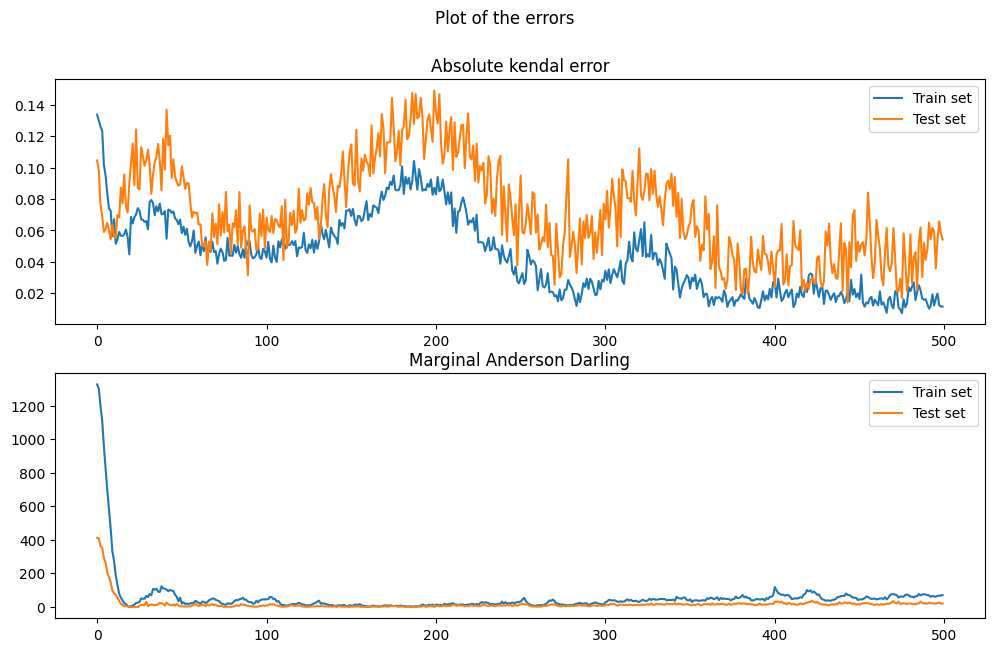

In [ ]:
plot_error(ake_train_list,
               ake_test_list,
               mad_train_list,
               mad_test_list)

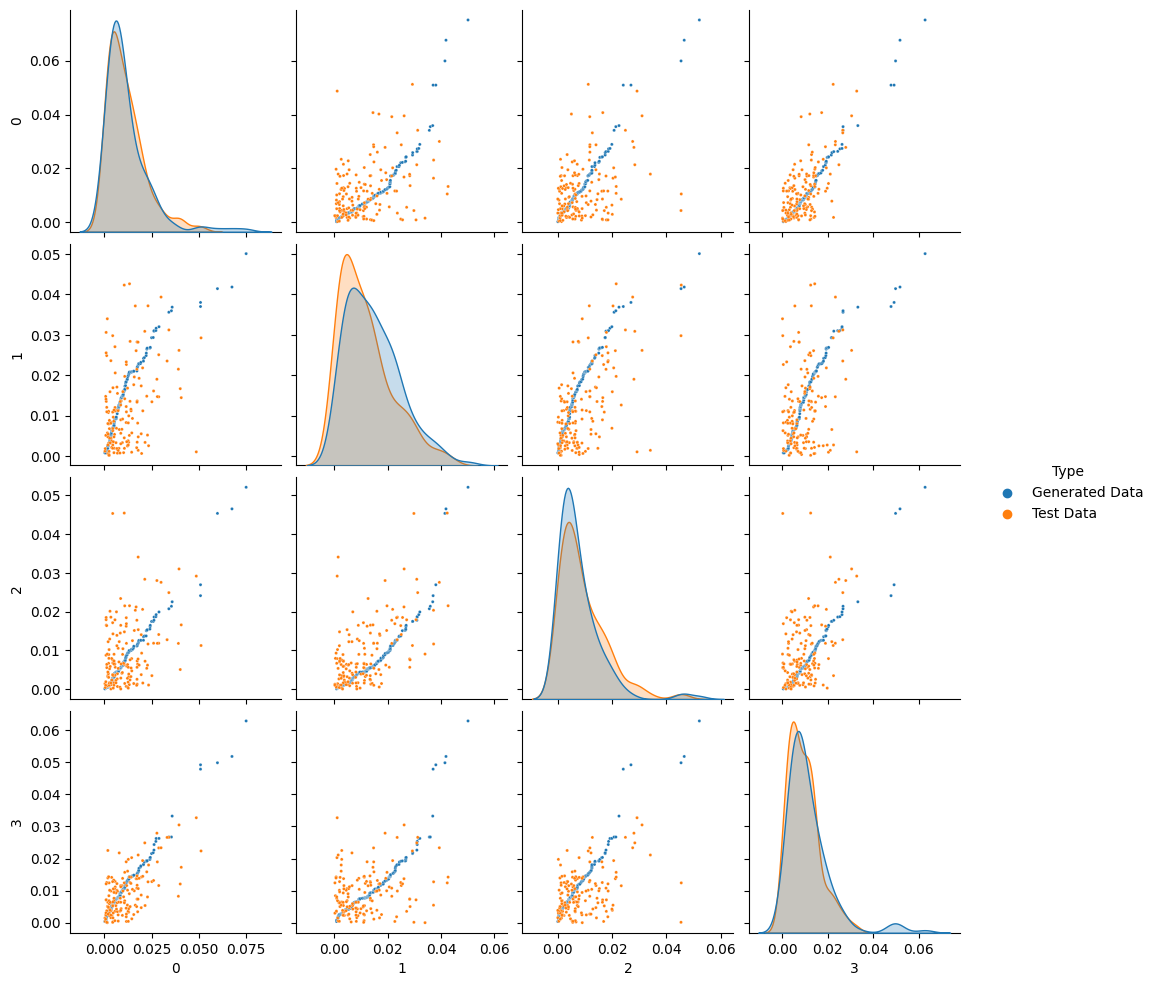

In [ ]:
plot_pair_plot(fakeData_shifting, X_test)

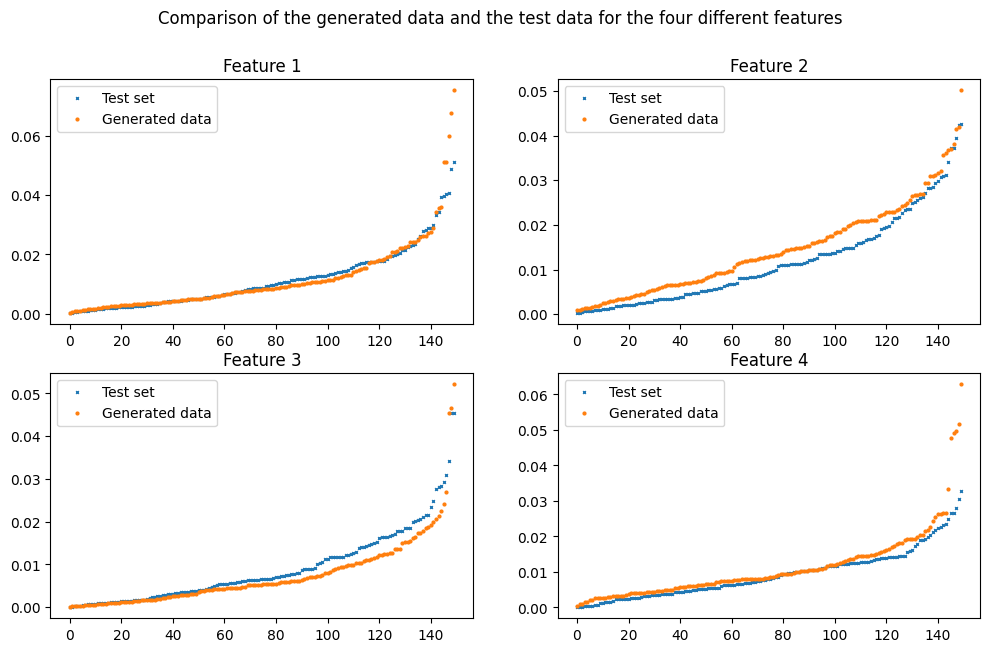

In [ ]:
plot_generation(fakeData_shifting)

## III. Third solution: evt-GAN

This method is based on the one described in Boulaguiem, Younes, et al. "Modeling and simulating spatial extremes by combining extreme value theory with generative adversarial networks." Environmental Data Science 1 (2022): e5.

Once again, we will keep the paper's notation.

In [ ]:
def infer_evtGAN(generator_evt, X_test, scaler_Z, shape_Z):
  with torch.no_grad() :
    noisy_input = Variable(torch.randn(len(X_test), n_input_G)).to(device)

    fakeData_evt = generator_evt(noisy_input).cpu().numpy()

    # as the generator was trained on U, we have first to descale the data so that it is in [0,1]
    # fakeData_evt = scaler_U.inverse_transform(fakeData_evt)
    # then we consider G^-1
    fakeData_evt = np.array([stats.genextreme.ppf(fakeData_evt[:,d], shape_Z[d]) for d in range(len(shape_Z))]).T
    # and inverse the standard scaling
    fakeData_evt = scaler_Z.inverse_transform(fakeData_evt)
    return fakeData_evt

In [ ]:
def run_evtGAN(generator : Generator,
               discriminator : Discriminator,
               block_size : int,
               n_epoch : int,
               verbeux : bool = True,
               metrics : bool = True) -> Tuple[MinMaxScaler, np.ndarray, StandardScaler] :

  '''
    block_size : the size of the blocks defining Z
    n_epoch : number of epochs for the training of each GAN

  In addition to updating the generator and the discriminator, also returns a numpy
  array containing the parameters of the GEV distribution and the scalers used to
  scale U and standard-scale the Z - useful to invert the generated data'''

  n_train,n_features = X_train_torch.shape
  n_blocks = n_train // block_size

  # as the original size of the train test is not necessarily a multiple of the size of the blocks
  X_train2 = X_train[:n_blocks*block_size]
  X_train2 = np.reshape(X_train2, (n_blocks, block_size, 4))

  # creating Z as the maximum value of each dimension for each block
  Z = X_train2.max(1)

  # in order to fit the GEV distribution, we first need to fit a standard scaler, as the data to fit
  # has to be standard-scaled (the fit method of scipy takes standard-scaled values as input)
  scaler_Z = StandardScaler()
  Z_scaled = scaler_Z.fit_transform(Z)

  # fitting Z (getting the shape parameter) with a GEV distribution for each dimension
  shape_Z = np.zeros(n_features)
  for d in range(n_features):
    fit_Z = stats.fit(stats.genextreme, Z_scaled[:,d], bounds = {'c' : (-20,20)})
    shape_Z[d] = fit_Z.params.c

  # Normalizing all margins according to the distribution
  U = np.array([stats.genextreme.cdf(Z_scaled[:,d], shape_Z[d]) for d in range(n_features)]).T
  U = torch.from_numpy(U).to(torch.float32).to(device)
  U_dataloader = TensorDataset(U)
  U_dataloader = DataLoader(U_dataloader, batch_size=batch_size, shuffle=True)

  ake_train_list, ake_test_list, mad_train_list, mad_test_list = train_GAN(U_dataloader, generator_evt, discriminator_evt, n_epoch_evt, verbeux, gaussian=False, infer_func=lambda x,y:infer_evtGAN(x,y, scaler_Z, shape_Z), metrics=metrics)

  return shape_Z, scaler_Z, ake_train_list, ake_test_list, mad_train_list, mad_test_list

In [ ]:
generator_evt = Generator(n_input_G, n_hidden_sizeG, n_output_G, activation=nn.Sigmoid()).to(device)
discriminator_evt = Discriminator(n_output_G, n_hidden_sizeD1, n_hidden_sizeD2).to(device)

criterion = nn.BCELoss()

optimizerG = optim.Adam(generator_evt.parameters(), lr=0.0001)
optimizerD = optim.Adam(discriminator_evt.parameters(), lr=0.0001)

block_size = 5
n_epoch_evt = 30

shape_Z, scaler_Z, ake_train_list, ake_test_list, mad_train_list, mad_test_list = run_evtGAN(generator_evt,
                                                                                            discriminator_evt,
                                                                                            block_size,
                                                                                            n_epoch_evt,
                                                                                            verbeux = True)

Epoch: 29 : lossG: 1.3579127788543701 | lossD: 0.965157687664032 | Absolute kental error Train : 0.22851785009305736 | Absolute kental error Test: 0.27360178970917226 |Marginal Anderson Darling Train : 184.49120542042866 | Marginal Anderson Darling Test: 59.85426042157913

In [ ]:
fakeData_evt = infer_evtGAN(generator_evt, X_train, scaler_Z, shape_Z)
absolute_kental_error_train = absolute_kental_error(fakeData_evt, X_train)
print(f"Absolute kental error Train: {absolute_kental_error_train}")
marginal_anderson_darling_train = marginal_anderson_darling(fakeData_evt, X_train)
print(f"Marginal Anderson Darling Train: {marginal_anderson_darling_train}")

fakeData_evt = infer_evtGAN(generator_evt, X_test, scaler_Z, shape_Z)
absolute_kental_error_test = absolute_kental_error(fakeData_evt, X_test)
print(f"Absolute kental error Test: {absolute_kental_error_test}")
marginal_anderson_darling_test = marginal_anderson_darling(fakeData_evt, X_test)
print(f"Marginal Anderson Darling Test: {marginal_anderson_darling_test}")

Absolute kental error Train: 0.23467091534600415
Marginal Anderson Darling Train: 173.06845889701435
Absolute kental error Test: 0.2778970917225951
Marginal Anderson Darling Test: 66.01769445711344


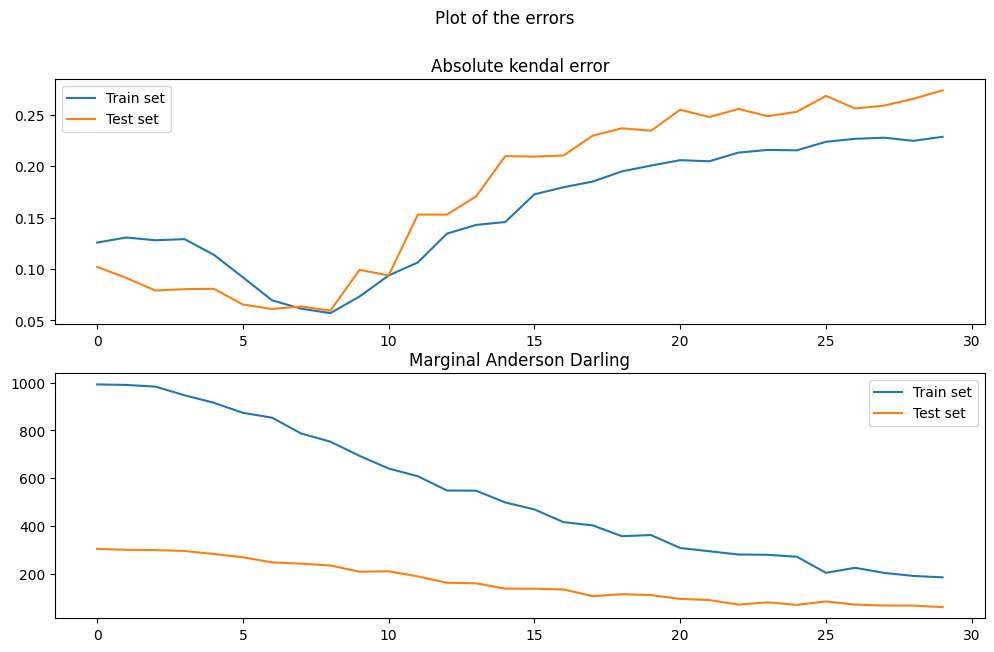

In [ ]:
plot_error(ake_train_list,
               ake_test_list,
               mad_train_list,
               mad_test_list)

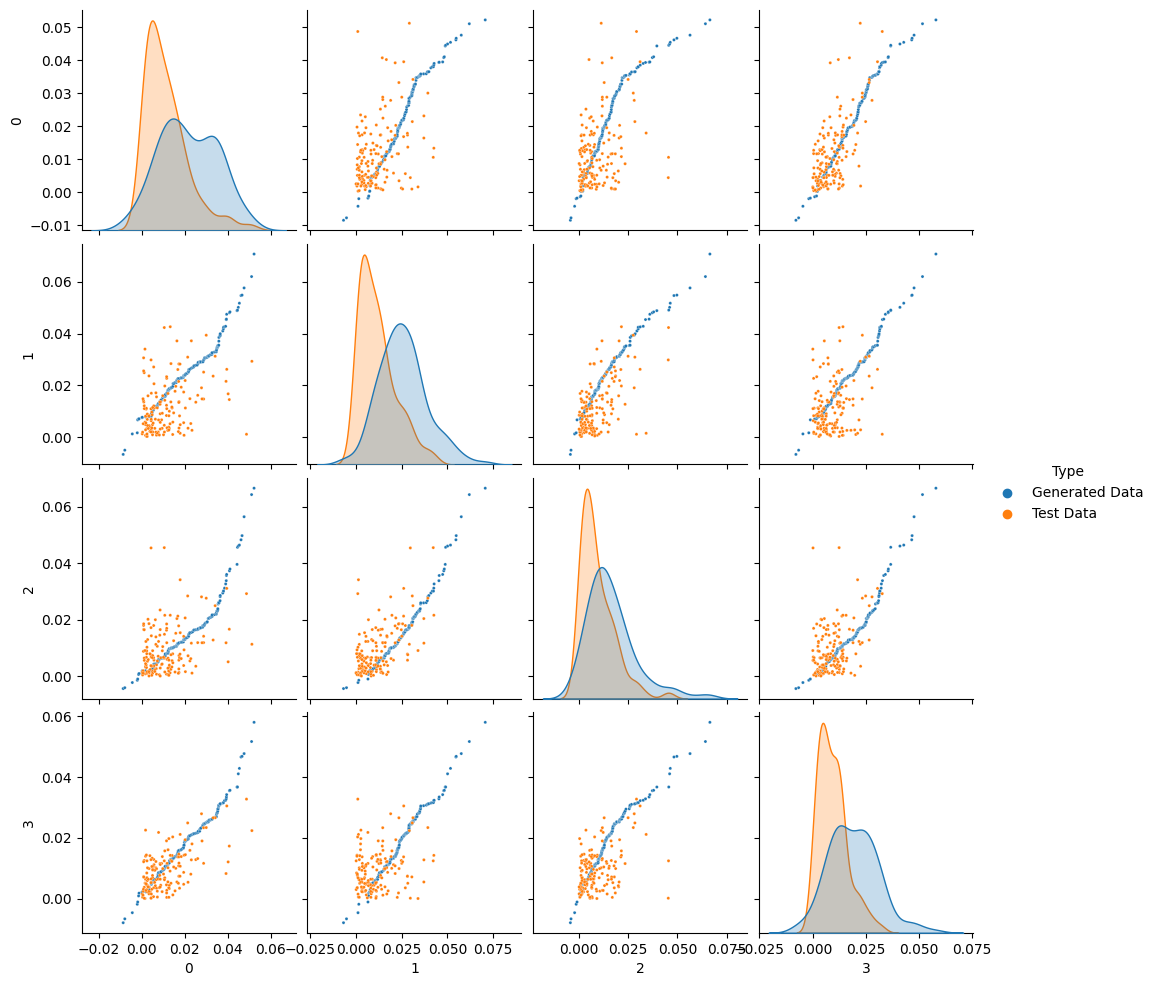

In [ ]:
plot_pair_plot(fakeData_evt, X_test)

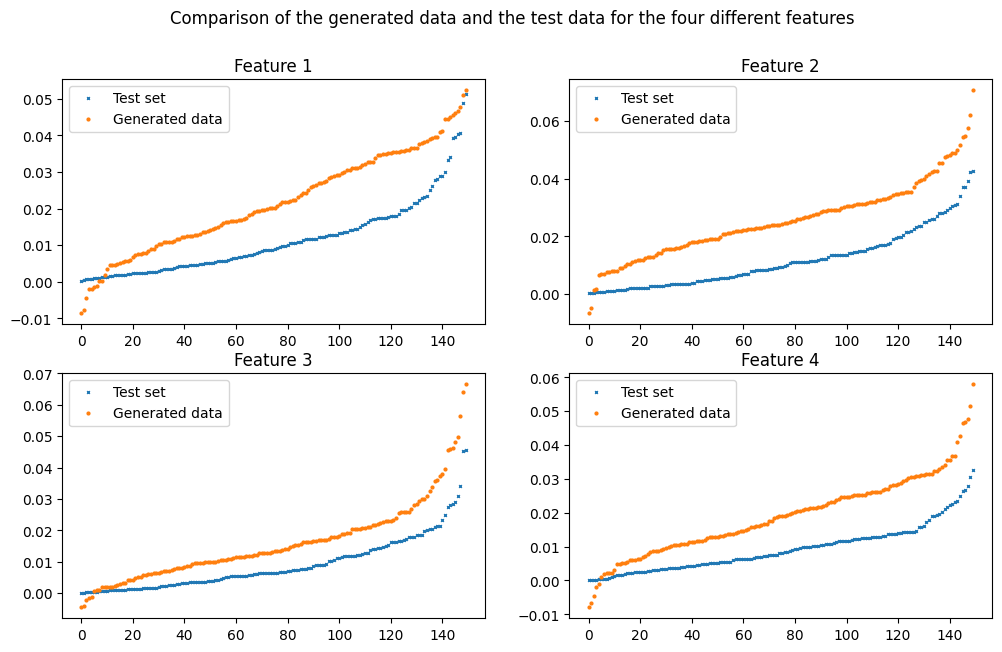

In [ ]:
plot_generation(fakeData_evt)

## IV. Fourth solution: EV-GAN

This method is based on the one described in Gobet, Michaël Allouche Stéphane Girard Emmanuel. "EV-GAN: Simulation of extreme events with ReLU neural networks." (2022).

We will keep the paper's notation.

In [ ]:
class Generator_EV_GAN(nn.Module):

  def __init__(self, n_input, n_hidden_size, n_output=4):

    super(Generator_EV_GAN, self).__init__()

    self.linear1 = nn.Linear(n_input, n_hidden_size)
    # Hack 4 : Use batch normalization : doesn't work
    self.batchnorm1 = nn.BatchNorm1d(n_hidden_size)
    self.relu1 = nn.LeakyReLU()
    # Hack 17 : Use dropout in both train and test
    self.dropout1 = nn.Dropout()
    self.linear2 = nn.Linear(n_hidden_size, n_output)

    self.g = lambda u : -4*u**5 + 5*u**4
    self.h = lambda u : u**3 -2*u**2 + u
    self.phi1 = lambda u : 1/(torch.log(1-u))
    self.phi2 = lambda u : 1/((torch.log(1-u))**2)
    # to compute the logarithmic integral function, we use a scipy function, which
    # of course needs a Tensor without autograd and on cpu (then converted back to
    # the device)
    self.li = lambda u : log1p(u.detach().cpu()).to(device)

    self.Phi0 = self.phi1
    self.Phi1 = lambda u : -self.li(1-u)
    self.Phi2 = lambda u : self.Phi1(u) + (1-u)*self.phi1(u)
    self.Phi3 = lambda u : (self.Phi1(u) + (1-u)*(self.phi1(u) + self.phi2(u)))/2

    # the ei are of shape batch_sizex4
    self.e1 = self.g
    self.e2 = self.h
    self.e3 = lambda u : self.g(u)*self.Phi0(u)
    self.e4 = lambda u : self.g(u)*self.Phi1(u)
    self.e5 = lambda u : self.g(u)*self.Phi2(u)
    self.e6 = lambda u : self.g(u)*self.Phi3(u)
    # e is of size batch_sizex6x4
    self.e = lambda u : torch.stack([self.e1(u),
                                     self.e2(u),
                                     self.e3(u),
                                     self.e4(u),
                                     self.e5(u),
                                     self.e6(u)], dim=1)

    # a kappa for each feature (as discussed in equation (6) in the paper)
    # in this setting, we have d=4, so there are 4 different kappas
    self.kappa1 = nn.Parameter(torch.randn(6, requires_grad=True))
    self.kappa2 = nn.Parameter(torch.randn(6, requires_grad=True))
    self.kappa3 = nn.Parameter(torch.randn(6, requires_grad=True))
    self.kappa4 = nn.Parameter(torch.randn(6, requires_grad=True))

    self.H_inverse = lambda z,x : torch.exp( -x * torch.log( ( (1-z*z) /2 ) ) )

  def forward(self, z):

    # Neural network part like conventional GANs which approximates f_ctif
    x = self.linear1(z)
    x = self.relu1(x)
    x = self.dropout1(x)
    x = self.linear2(x)

    # Regularization term
    ex = self.e(z)

    regul1 = ex[:,:,0] @ self.kappa1
    regul2 = ex[:,:,1] @ self.kappa2
    regul3 = ex[:,:,2] @ self.kappa3
    regul4 = ex[:,:,3] @ self.kappa4

    regul = torch.stack([regul1, regul2, regul3, regul4], dim=1)

    # Approximatif of f_tif by adding the two terms
    x = x + regul

    # Inversion to get back the quantiles using the approximation and the original noise
    H_inverse1 = self.H_inverse(z[:,0], x[:,0])
    H_inverse2 = self.H_inverse(z[:,1], x[:,1])
    H_inverse3 = self.H_inverse(z[:,2], x[:,2])
    H_inverse4 = self.H_inverse(z[:,3], x[:,3])
    H_inverse = torch.stack([H_inverse1, H_inverse2, H_inverse3, H_inverse4], dim=1)
    return H_inverse

In [ ]:
def infer_EVGAN(generator : Generator, X_infer : np.ndarray = X_test):
  with torch.no_grad():
    noisy_input = Variable(torch.rand(len(X_infer), n_input_G)).to(device)

    fakeData_ev_gan = generator_ev_gan(noisy_input).cpu().numpy()
  return fakeData_ev_gan

In [ ]:
batch_size=8
X_train_torch_not_scaled = torch.from_numpy(X_train).to(torch.float32).to(device)
X_train_dataloader_not_scaled = TensorDataset(X_train_torch_not_scaled)
X_train_dataloader_not_scaled = DataLoader(X_train_dataloader_not_scaled, batch_size=batch_size, shuffle=True)

In [ ]:
n_input_G = 8
n_hidden_sizeG = 20
n_hidden_sizeD1 = 30
n_hidden_sizeD2 = 15
n_output_G = 4

generator_ev_gan = Generator_EV_GAN(n_input_G, n_hidden_sizeG, n_output_G).to(device)
discriminator_ev_gan = Discriminator(n_output_G, n_hidden_sizeD1, n_hidden_sizeD2).to(device)

criterion = nn.BCELoss()

optimizerG = optim.Adam(generator_ev_gan.parameters(), lr=0.0001)
optimizerD = optim.Adam(discriminator_ev_gan.parameters(), lr=0.0001)

n_epoch_ev_GAN = 100

In [ ]:
ake_train_list, ake_test_list, mad_train_list, mad_test_list = train_GAN(X_train_dataloader_not_scaled, generator_ev_gan, discriminator_ev_gan, n_epoch_ev_GAN, gaussian=False, infer_func=infer_EVGAN)

In [ ]:
fakeData_ev_gan = infer_EVGAN(generator_ev_gan)
absolute_kental_error_test = absolute_kental_error(fakeData_ev_gan, X_test)
print(f"Absolute kental error Test: {absolute_kental_error_test}")
marginal_anderson_darling_test = marginal_anderson_darling(fakeData_ev_gan, X_test)
print(f"Marginal Anderson Darling Test: {marginal_anderson_darling_test}")

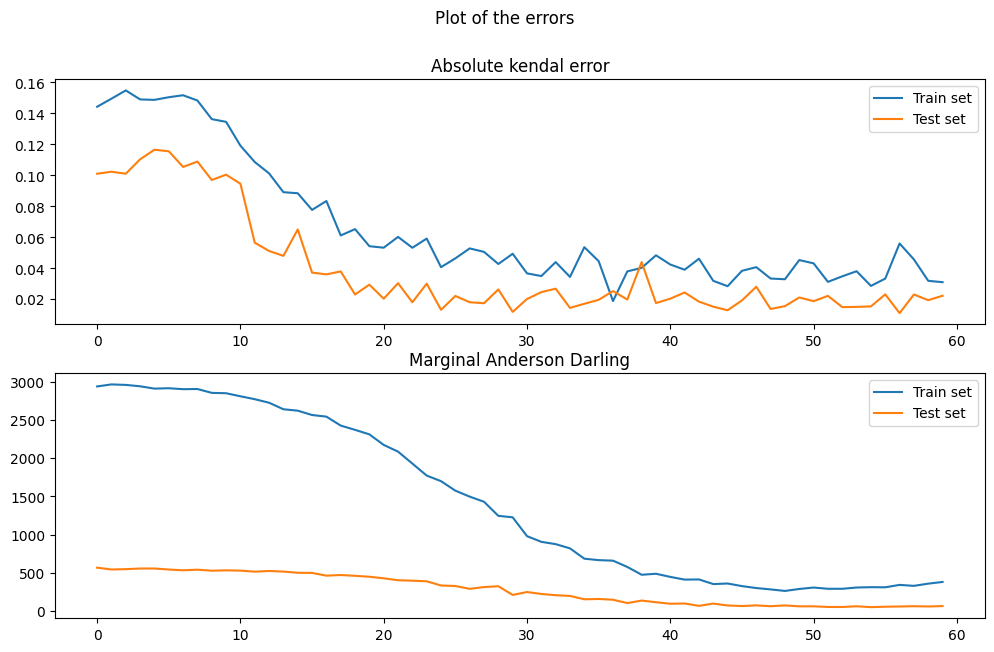

In [ ]:
plot_error(ake_train_list,
               ake_test_list,
               mad_train_list,
               mad_test_list)

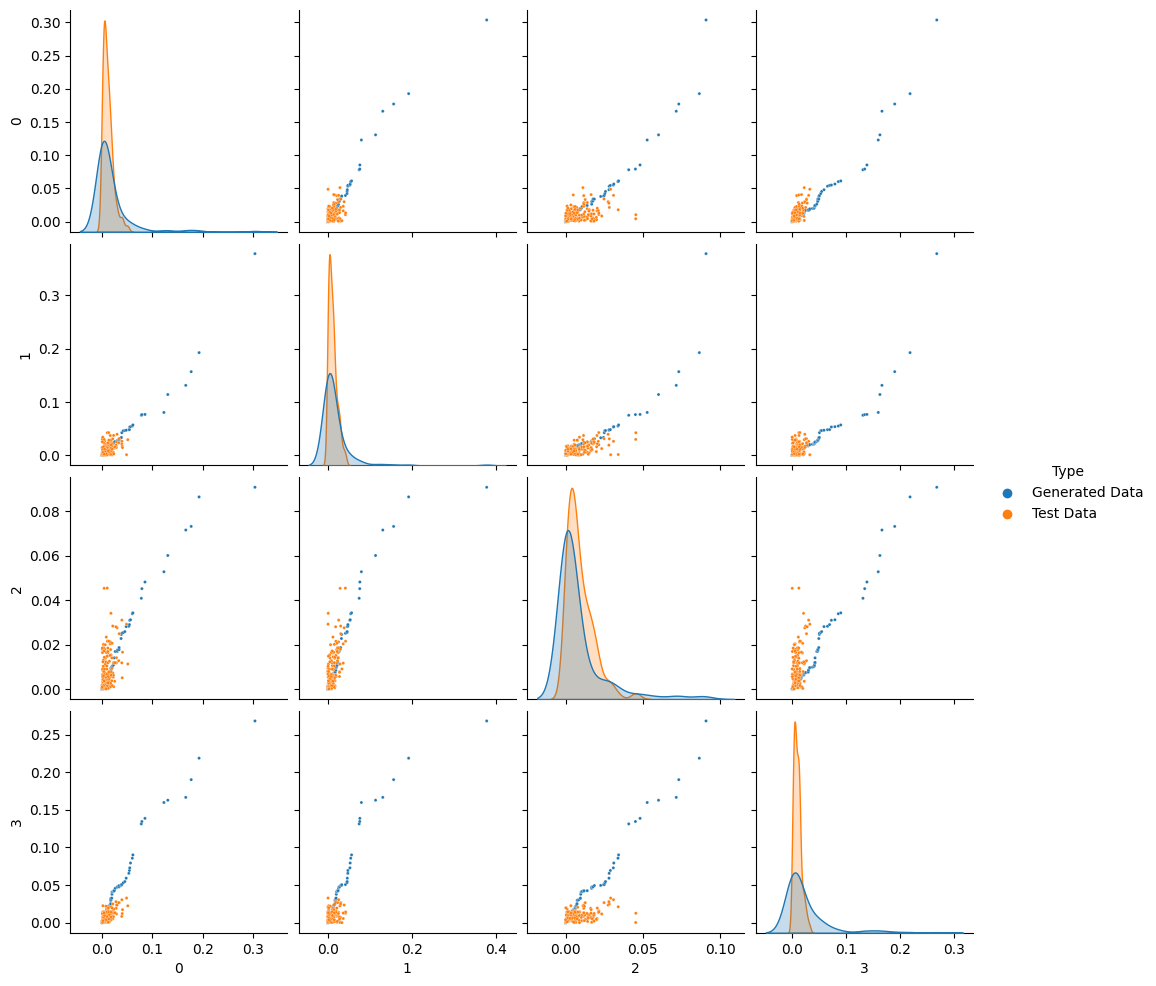

In [ ]:
plot_pair_plot(fakeData_ev_gan, X_test)

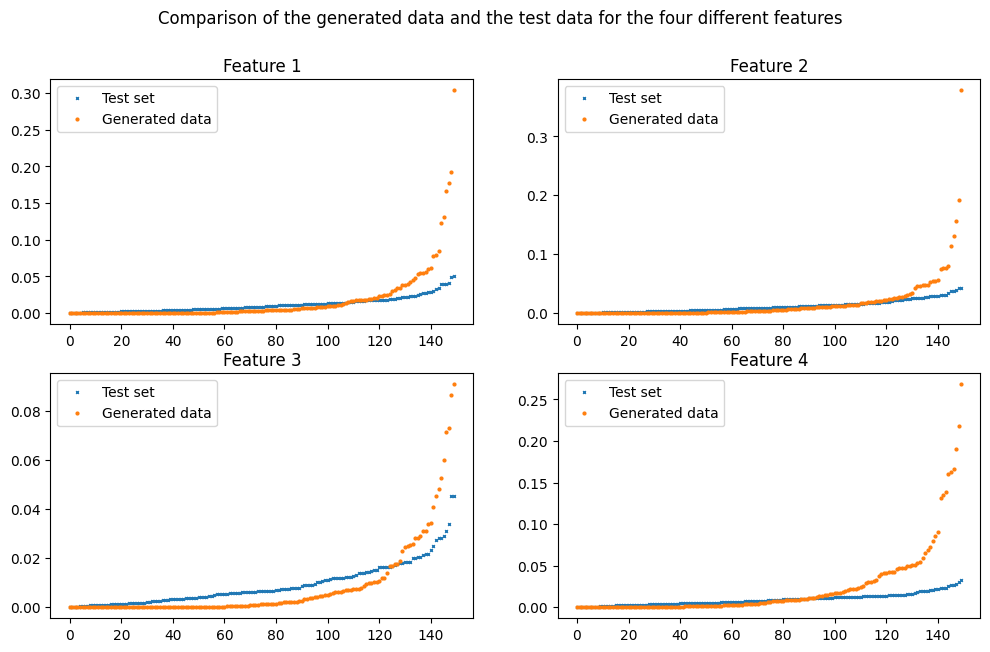

In [ ]:
plot_generation(fakeData_ev_gan, X_plot=X_test)

# Saving best model

After finding the best model (here the ExGAN model) we save it alongside its scaler

In [ ]:
# torch.save(generator_shifting, "model/generator_model_distribution_shifting")

In [ ]:
# import joblib
# joblib.dump(my_scaler, 'model/scaler.gz')